# (MBTI) Myers-Briggs Personality Type Prediction

* Extroversion vs. Introversion
    * I - 0
    * E - 1 
    
* Sensing vs. Intuition 
    * N - 0 
    * S - 1
    
* Thinking vs. Feeling
    * F - 0
    * T - 1
    
* Judging vs. Perceiving
    * P - 0
    * J - 1 
    
## IMPLEMENTING DIFFERENT MODELS 

In [1]:
# importing dependencies here
import numpy as np
import pandas as pd

# visualizations
import seaborn as sns
import matplotlib.pyplot as plt

# data stratifying and splitting
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split

# preprocessing
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import make_pipeline
from sklearn.feature_selection import f_classif
from sklearn.feature_selection import SelectKBest
from sklearn.compose import ColumnTransformer

# class imbalance
from imblearn.pipeline import make_pipeline as imb_make_pipeline
from imblearn.under_sampling import RandomUnderSampler

# algorithms/models
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier

# model evaluation
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import (
    classification_report,
    f1_score,
    accuracy_score,
    roc_auc_score,
)

# performance check
import time
import warnings

warnings.filterwarnings("ignore")

# sparse to dense
from sklearn.base import TransformerMixin


class DenseTransformer(TransformerMixin):
    def fit(self, X, y=None, **fit_params):
        return self

    def transform(self, X, y=None, **fit_params):
        return X.todense()


# saving the model
from joblib import dump

# code formatter
%load_ext nb_black

<IPython.core.display.Javascript object>

In [2]:
# reading the final datasets
personality_data = pd.read_csv("data_ekta/clean_data_3.csv")

<IPython.core.display.Javascript object>

In [3]:
# checking counts dataset
personality_data.head(2)

,type,is_Extrovert,is_Sensing,is_Thinking,is_Judging,posts,clean_posts,compound_sentiment,pos_sentiment,neg_sentiment,...,em,colons,emojis,word_count,unique_words,post_length_var,upper,link_count,ellipses,img_count
0,INFJ,0,0,0,1,'When asked of the things you wish you did ear...,asked thing wish earlier find answering...,0.99980,0.414667,0.136150,...,0.22,0.32,0.08,30.98,14.92,78.414931,1.46,0.04,0.62,0.0
1,INFJ,0,0,0,1,'I love both and they are equally important to...,love equally important music window soul in...,0.99995,0.596000,0.134585,...,0.36,0.14,0.00,28.58,12.72,160.744400,1.62,0.02,0.04,0.0


<IPython.core.display.Javascript object>

### Setting predictors and target variable


In [4]:
# setting X to clean_posts, compound sentiment score, pos tags and various other counts
X = personality_data[
    [
        "clean_posts",
        "compound_sentiment",
        "ADJ_avg",
        "ADP_avg",
        "ADV_avg",
        "CONJ_avg",
        "DET_avg",
        "NOUN_avg",
        "NUM_avg",
        "PRT_avg",
        "PRON_avg",
        "VERB_avg",
        "qm",
        "em",
        "colons",
        "emojis",
        "word_count",
        "unique_words",
        "upper",
        "link_count",
        "ellipses",
        "img_count",
    ]
]

# setting y to four targets is_Extrovert, is_Sensing, is_Thinking, is_Judging
y = personality_data.iloc[:, 1:5]

# ensuring that X and y row count matches
print(X.shape)
print(y.shape)

(8588, 22)
(8588, 4)


<IPython.core.display.Javascript object>

### Creating a list of words (other than the stop words) to be dropped to improve model performanace

In [5]:
additional_stopwords = ["hey", "hello", "briggs", "cat", "car", "mbti", "soup"]

<IPython.core.display.Javascript object>

### Setting up preprocessor for vectorization and selecting best counts and scores

In [6]:
# preprocessing steps for selecting best k columns/features from counts & scores and for vectorizing words

counts_n_scores = [
    "compound_sentiment",
    "ADJ_avg",
    "ADP_avg",
    "ADV_avg",
    "CONJ_avg",
    "DET_avg",
    "NOUN_avg",
    "NUM_avg",
    "PRT_avg",
    "PRON_avg",
    "VERB_avg",
    "qm",
    "em",
    "colons",
    "emojis",
    "word_count",
    "unique_words",
    "upper",
    "link_count",
    "ellipses",
    "img_count",
]

# for selecting k best features from features other than words
best_k_features = make_pipeline(MinMaxScaler(), SelectKBest(f_classif, k=10))

# setting up preprocessing for TF-IDF vectorizer
preprocesser_tf = ColumnTransformer(
    transformers=[
        (
            "tfidf",
            TfidfVectorizer(min_df=25, max_df=0.85, stop_words=additional_stopwords),
            "clean_posts",
        ),
        ("selectbest", best_k_features, counts_n_scores),
    ],
    remainder="passthrough",
)

# setting up preprocessing for COUNT vectorizer
preprocesser_ct = ColumnTransformer(
    transformers=[
        (
            "ct_vect",
            CountVectorizer(min_df=25, max_df=0.85, stop_words=additional_stopwords),
            "clean_posts",
        ),
        ("selectbest", best_k_features, counts_n_scores),
    ],
    remainder="passthrough",
)

<IPython.core.display.Javascript object>

### Modelling

In [7]:
# setting up the personality dictionary for printing scores
mbti_type = {
    "is_Extrovert": "Extrovert vs Introvert",
    "is_Sensing": "Sensing vs Intuition",
    "is_Thinking": "Thinking vs Feeling",
    "is_Judging": "Judging vs Perceiving",
}

# function to build the model for predicting each of 4 target features
def build_model(model, X, y, vectorizer_name):

    for col in y.columns:

        print(f"\n{mbti_type[col]}")
        target = y[col]

        X_train, X_test, y_train, y_test = train_test_split(
            X, target, test_size=0.2, random_state=42, stratify=target
        )

        # model training
        model.fit(X_train, y_train)

        # model evaluation
        print(f"Accuracy: {model.score(X_test, y_test)} \n")
        print(classification_report(y_test, model.predict(X_test)))

<IPython.core.display.Javascript object>

### TF-IDF Logistic Regression

In [8]:
%%time
tfidf_logistic_regression = imb_make_pipeline(
    preprocesser_tf, RandomUnderSampler(), LogisticRegressionCV()
)
build_model(tfidf_logistic_regression, X, y, "tfidf")


Extrovert vs Introvert
Accuracy: 0.6880093131548312 

              precision    recall  f1-score   support

           0       0.87      0.69      0.77      1322
           1       0.40      0.67      0.50       396

    accuracy                           0.69      1718
   macro avg       0.63      0.68      0.64      1718
weighted avg       0.76      0.69      0.71      1718


Sensing vs Intuition
Accuracy: 0.6961583236321304 

              precision    recall  f1-score   support

           0       0.94      0.69      0.80      1481
           1       0.28      0.75      0.40       237

    accuracy                           0.70      1718
   macro avg       0.61      0.72      0.60      1718
weighted avg       0.85      0.70      0.74      1718


Thinking vs Feeling
Accuracy: 0.7852153667054714 

              precision    recall  f1-score   support

           0       0.81      0.78      0.80       929
           1       0.75      0.79      0.77       789

    accuracy          

<IPython.core.display.Javascript object>

### Count Vectorized Logistic Regression

In [9]:
%%time
ct_logistic_regression = imb_make_pipeline(
    preprocesser_ct, RandomUnderSampler(), LogisticRegressionCV()
)
build_model(ct_logistic_regression, X, y, "ct_vect")


Extrovert vs Introvert
Accuracy: 0.6542491268917345 

              precision    recall  f1-score   support

           0       0.85      0.67      0.75      1322
           1       0.35      0.59      0.44       396

    accuracy                           0.65      1718
   macro avg       0.60      0.63      0.60      1718
weighted avg       0.73      0.65      0.68      1718


Sensing vs Intuition
Accuracy: 0.6525029103608847 

              precision    recall  f1-score   support

           0       0.94      0.64      0.76      1481
           1       0.25      0.73      0.37       237

    accuracy                           0.65      1718
   macro avg       0.59      0.69      0.56      1718
weighted avg       0.84      0.65      0.71      1718


Thinking vs Feeling
Accuracy: 0.7759022118742724 

              precision    recall  f1-score   support

           0       0.81      0.77      0.79       929
           1       0.74      0.79      0.76       789

    accuracy          

<IPython.core.display.Javascript object>

### Cross Validated TF-IDF Logistic Lasso

In [10]:
%%time
tfidf_logistic_regression_lasso = imb_make_pipeline(
    preprocesser_tf, RandomUnderSampler(), LogisticRegressionCV(penalty='l1', solver='saga' )
)
build_model(tfidf_logistic_regression_lasso, X, y, "tfidf")


Extrovert vs Introvert
Accuracy: 0.6647264260768335 

              precision    recall  f1-score   support

           0       0.86      0.67      0.76      1322
           1       0.37      0.63      0.46       396

    accuracy                           0.66      1718
   macro avg       0.61      0.65      0.61      1718
weighted avg       0.75      0.66      0.69      1718


Sensing vs Intuition
Accuracy: 0.6786961583236322 

              precision    recall  f1-score   support

           0       0.94      0.67      0.78      1481
           1       0.26      0.75      0.39       237

    accuracy                           0.68      1718
   macro avg       0.60      0.71      0.59      1718
weighted avg       0.85      0.68      0.73      1718


Thinking vs Feeling
Accuracy: 0.7747380675203726 

              precision    recall  f1-score   support

           0       0.81      0.77      0.79       929
           1       0.74      0.78      0.76       789

    accuracy          

<IPython.core.display.Javascript object>

### Cross Validated Count Vectorized Logistic Lasso

In [11]:
%%time
ct_logistic_regression_lasso = imb_make_pipeline(
    preprocesser_ct, RandomUnderSampler(), LogisticRegressionCV(penalty='l1', solver='saga' )
)
build_model(ct_logistic_regression_lasso, X, y, "ct_vect")


Extrovert vs Introvert
Accuracy: 0.6542491268917345 

              precision    recall  f1-score   support

           0       0.86      0.66      0.75      1322
           1       0.36      0.64      0.46       396

    accuracy                           0.65      1718
   macro avg       0.61      0.65      0.60      1718
weighted avg       0.74      0.65      0.68      1718


Sensing vs Intuition
Accuracy: 0.6431897555296857 

              precision    recall  f1-score   support

           0       0.92      0.64      0.76      1481
           1       0.23      0.67      0.34       237

    accuracy                           0.64      1718
   macro avg       0.58      0.65      0.55      1718
weighted avg       0.83      0.64      0.70      1718


Thinking vs Feeling
Accuracy: 0.7555296856810244 

              precision    recall  f1-score   support

           0       0.79      0.75      0.77       929
           1       0.72      0.76      0.74       789

    accuracy          

<IPython.core.display.Javascript object>

### Cross Validated TF-IDF Logistic Ridge

In [12]:
%%time
tfidf_logistic_regression_ridge = imb_make_pipeline(
    preprocesser_tf, RandomUnderSampler(), LogisticRegressionCV(penalty='l2', solver='saga' )
)
build_model(tfidf_logistic_regression_ridge, X, y, "tfidf")


Extrovert vs Introvert
Accuracy: 0.6821885913853318 

              precision    recall  f1-score   support

           0       0.87      0.69      0.77      1322
           1       0.39      0.67      0.49       396

    accuracy                           0.68      1718
   macro avg       0.63      0.68      0.63      1718
weighted avg       0.76      0.68      0.71      1718


Sensing vs Intuition
Accuracy: 0.6926658905704307 

              precision    recall  f1-score   support

           0       0.94      0.68      0.79      1481
           1       0.27      0.75      0.40       237

    accuracy                           0.69      1718
   macro avg       0.61      0.72      0.60      1718
weighted avg       0.85      0.69      0.74      1718


Thinking vs Feeling
Accuracy: 0.7834691501746216 

              precision    recall  f1-score   support

           0       0.81      0.78      0.80       929
           1       0.76      0.78      0.77       789

    accuracy          

<IPython.core.display.Javascript object>

### Cross Validated Count Vectorized Logistic Ridge

In [13]:
%%time
ct_logistic_regression_ridge = imb_make_pipeline(
    preprocesser_ct, RandomUnderSampler(), LogisticRegressionCV(penalty='l2', solver='saga' )
)
build_model(ct_logistic_regression_ridge, X, y, "ct_vect")


Extrovert vs Introvert
Accuracy: 0.6653084982537835 

              precision    recall  f1-score   support

           0       0.86      0.68      0.76      1322
           1       0.37      0.63      0.46       396

    accuracy                           0.67      1718
   macro avg       0.61      0.65      0.61      1718
weighted avg       0.75      0.67      0.69      1718


Sensing vs Intuition
Accuracy: 0.689755529685681 

              precision    recall  f1-score   support

           0       0.94      0.69      0.79      1481
           1       0.27      0.71      0.39       237

    accuracy                           0.69      1718
   macro avg       0.60      0.70      0.59      1718
weighted avg       0.84      0.69      0.74      1718


Thinking vs Feeling
Accuracy: 0.7759022118742724 

              precision    recall  f1-score   support

           0       0.81      0.77      0.79       929
           1       0.74      0.78      0.76       789

    accuracy           

<IPython.core.display.Javascript object>

### TF-IDF Logistic Elasticnet

* Takes longest to run and the results are almost same as lasso and ridge model. So this code is commented to save time when re-running the entire notebook.

In [14]:
# %%time

# for col in y.columns:

#     print(f"\n{mbti_type[col]}")

#     target = y[col]

#     X_train, X_test, y_train, y_test = train_test_split(
#         X, target, test_size=0.2, random_state=42, stratify=target
#     )

#     tfidf_logistic_regression_elasticnet = imb_make_pipeline(
#         preprocesser_tf,
#     #     DenseTransformer(),
#         RandomUnderSampler(),
#         LogisticRegressionCV(
#             penalty='elasticnet',
#             l1_ratios=[0, .1, .2, .3, .4, .5, .6, .7, .8, .9, 1],
#             solver='saga'
#         )
#     )

#     tfidf_logistic_regression_elasticnet.fit(X_train, y_train)

#     print(f'Accuracy: {tfidf_logistic_regression_elasticnet.score(X_test, y_test)} \n')
#     print(classification_report(y_test, tfidf_logistic_regression_elasticnet.predict(X_test)))

<IPython.core.display.Javascript object>

### TF-IDF Support Vector Classifier

In [15]:
%%time
tfidf_svc = imb_make_pipeline(
    preprocesser_tf, RandomUnderSampler(), DenseTransformer(), LinearSVC()
)
build_model(tfidf_svc, X, y, "tfidf")


Extrovert vs Introvert
Accuracy: 0.6688009313154831 

              precision    recall  f1-score   support

           0       0.88      0.66      0.76      1322
           1       0.38      0.68      0.49       396

    accuracy                           0.67      1718
   macro avg       0.63      0.67      0.62      1718
weighted avg       0.76      0.67      0.69      1718


Sensing vs Intuition
Accuracy: 0.6839348079161816 

              precision    recall  f1-score   support

           0       0.94      0.68      0.79      1481
           1       0.26      0.71      0.38       237

    accuracy                           0.68      1718
   macro avg       0.60      0.69      0.58      1718
weighted avg       0.84      0.68      0.73      1718


Thinking vs Feeling
Accuracy: 0.779976717112922 

              precision    recall  f1-score   support

           0       0.80      0.78      0.79       929
           1       0.75      0.77      0.76       789

    accuracy           

<IPython.core.display.Javascript object>

### Count Vectorized Support Vector Classifier

In [16]:
%%time
ct_svc = imb_make_pipeline(
    preprocesser_ct, DenseTransformer(), RandomUnderSampler(), LinearSVC()
)
build_model(ct_svc, X, y, "ct_vect")


Extrovert vs Introvert
Accuracy: 0.610011641443539 

              precision    recall  f1-score   support

           0       0.84      0.61      0.71      1322
           1       0.32      0.62      0.42       396

    accuracy                           0.61      1718
   macro avg       0.58      0.61      0.56      1718
weighted avg       0.72      0.61      0.64      1718


Sensing vs Intuition
Accuracy: 0.6251455180442375 

              precision    recall  f1-score   support

           0       0.92      0.62      0.74      1481
           1       0.22      0.65      0.32       237

    accuracy                           0.63      1718
   macro avg       0.57      0.64      0.53      1718
weighted avg       0.82      0.63      0.68      1718


Thinking vs Feeling
Accuracy: 0.7281722933643772 

              precision    recall  f1-score   support

           0       0.76      0.74      0.75       929
           1       0.70      0.72      0.71       789

    accuracy           

<IPython.core.display.Javascript object>

### TF-IDF Naive Bayes

In [17]:
%%time
tfidf_nb = imb_make_pipeline(
    preprocesser_tf, DenseTransformer(), RandomUnderSampler(), MultinomialNB(),
)
build_model(tfidf_nb, X, y, "tfidf")


Extrovert vs Introvert
Accuracy: 0.669965075669383 

              precision    recall  f1-score   support

           0       0.90      0.65      0.75      1322
           1       0.39      0.75      0.51       396

    accuracy                           0.67      1718
   macro avg       0.64      0.70      0.63      1718
weighted avg       0.78      0.67      0.70      1718


Sensing vs Intuition
Accuracy: 0.6734575087310827 

              precision    recall  f1-score   support

           0       0.94      0.66      0.78      1481
           1       0.26      0.76      0.39       237

    accuracy                           0.67      1718
   macro avg       0.60      0.71      0.58      1718
weighted avg       0.85      0.67      0.72      1718


Thinking vs Feeling
Accuracy: 0.7683352735739232 

              precision    recall  f1-score   support

           0       0.77      0.82      0.79       929
           1       0.77      0.71      0.74       789

    accuracy           

<IPython.core.display.Javascript object>

### Count Vectorized Naive Bayes

In [18]:
%%time
ct_nb = imb_make_pipeline(
    preprocesser_ct, DenseTransformer(), RandomUnderSampler(), MultinomialNB(),
)
build_model(ct_nb, X, y, "ct_vect")


Extrovert vs Introvert
Accuracy: 0.6629802095459837 

              precision    recall  f1-score   support

           0       0.88      0.65      0.75      1322
           1       0.38      0.71      0.49       396

    accuracy                           0.66      1718
   macro avg       0.63      0.68      0.62      1718
weighted avg       0.77      0.66      0.69      1718


Sensing vs Intuition
Accuracy: 0.7095459837019791 

              precision    recall  f1-score   support

           0       0.95      0.70      0.81      1481
           1       0.29      0.75      0.42       237

    accuracy                           0.71      1718
   macro avg       0.62      0.73      0.61      1718
weighted avg       0.86      0.71      0.75      1718


Thinking vs Feeling
Accuracy: 0.7735739231664727 

              precision    recall  f1-score   support

           0       0.79      0.78      0.79       929
           1       0.75      0.76      0.76       789

    accuracy          

<IPython.core.display.Javascript object>

### Count Vectorized Random Forest

In [19]:
%%time
ct_rf = imb_make_pipeline(
    preprocesser_ct, RandomUnderSampler(), RandomForestClassifier(n_estimators=100, max_depth=10),
)
build_model(ct_rf, X, y, "ct_vect")


Extrovert vs Introvert
Accuracy: 0.6431897555296857 

              precision    recall  f1-score   support

           0       0.86      0.64      0.74      1322
           1       0.35      0.64      0.45       396

    accuracy                           0.64      1718
   macro avg       0.60      0.64      0.59      1718
weighted avg       0.74      0.64      0.67      1718


Sensing vs Intuition
Accuracy: 0.6519208381839348 

              precision    recall  f1-score   support

           0       0.93      0.65      0.76      1481
           1       0.24      0.68      0.35       237

    accuracy                           0.65      1718
   macro avg       0.58      0.66      0.56      1718
weighted avg       0.83      0.65      0.71      1718


Thinking vs Feeling
Accuracy: 0.7339930151338766 

              precision    recall  f1-score   support

           0       0.78      0.70      0.74       929
           1       0.69      0.77      0.73       789

    accuracy          

<IPython.core.display.Javascript object>

### TF-IDF Random Forest

In [20]:
%%time
tfidf_rf = imb_make_pipeline(
    preprocesser_tf, DenseTransformer(),
        RandomUnderSampler(),
        RandomForestClassifier(n_estimators=100, max_depth=10),
)
build_model(tfidf_rf, X, y, "tfidf")


Extrovert vs Introvert
Accuracy: 0.6501746216530849 

              precision    recall  f1-score   support

           0       0.86      0.65      0.74      1322
           1       0.36      0.65      0.46       396

    accuracy                           0.65      1718
   macro avg       0.61      0.65      0.60      1718
weighted avg       0.74      0.65      0.68      1718


Sensing vs Intuition
Accuracy: 0.6362048894062864 

              precision    recall  f1-score   support

           0       0.92      0.64      0.75      1481
           1       0.22      0.64      0.33       237

    accuracy                           0.64      1718
   macro avg       0.57      0.64      0.54      1718
weighted avg       0.82      0.64      0.69      1718


Thinking vs Feeling
Accuracy: 0.7444703143189756 

              precision    recall  f1-score   support

           0       0.79      0.72      0.75       929
           1       0.70      0.77      0.74       789

    accuracy          

<IPython.core.display.Javascript object>

### Final Model - Logistic Regression with TF-IDF Vectorization

Selecting Logistic Regression as our final model as it returned the highest accuracy, precision and recall values as compared to other models.


Extrovert vs Introvert
                 coef
word                 
fun          3.725748
friend       2.860645
family      -2.804771
debate       2.680547
guy          2.608624
ego          2.600346
business     2.577903
bored        2.542068
still       -2.471127
dated        2.457804
challenge    2.450150
see          2.387219
father      -2.279080
mother      -2.237088
nature      -2.232370
feel        -2.221827
cold        -2.141462
instinctual  2.136730
crazy        2.109644
distracted   2.099245
awesome      2.094953

Sensing vs Intuition
              coef
word              
type      3.668527
idea     -2.777214
rant      2.746447
world    -2.643953
human    -2.214944
sensor    2.175281
dark     -2.152958
rave      2.131513
fun       2.107908
everyone -1.995053
thought  -1.980122
many     -1.931583
study    -1.916934
stuff     1.898716
need      1.897358
dont      1.890488
dominant  1.886697
book     -1.867729
husband   1.856377
story     1.790571
ill       1.783492

Thinking v

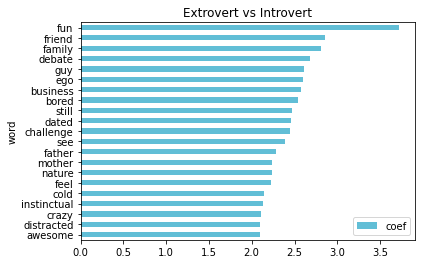

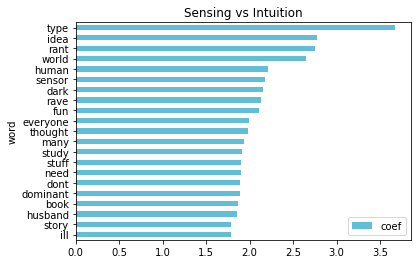

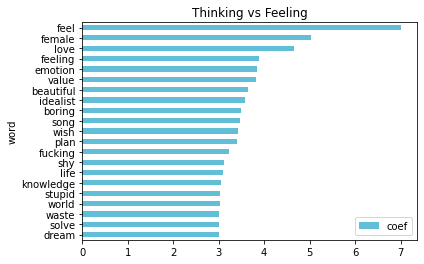

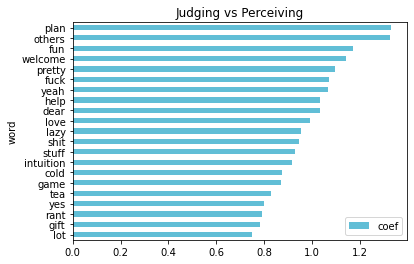

<IPython.core.display.Javascript object>

In [21]:
%%time

for col in y.columns:
    
    print(f"\n{mbti_type[col]}")

    target = y[col]

    tfidf_logistic_regression = imb_make_pipeline(
        preprocesser_tf,
        RandomUnderSampler(),
        LogisticRegressionCV()
    )
    
    # training the data on entire dataset
    tfidf_logistic_regression.fit(X, target)
    
    # feature importance   
    coef = tfidf_logistic_regression[-1].coef_[0]  
    word = tfidf_logistic_regression[0].named_transformers_['tfidf'].get_feature_names()
    word_list = list(zip(word, coef))         
    result = pd.DataFrame(word_list, columns=['word', 'coef']).set_index('word')    
    result = result.reindex(result.coef.abs().sort_values(ascending=False).index)[0:21]
    print(result)
    
    # plotting feature importance
    result["coef"] = result["coef"].apply(lambda x: abs(x))
    result.sort_values("coef", inplace=True)
    result.plot(kind="barh", color="#61BED6", title=mbti_type[col])
  
    # saving the model
    dump(tfidf_logistic_regression, f"clf_{col}.joblib")